In [1]:
#!sudo apt install tesseract-ocr
#!pip install pytesseract

import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
import os
import matplotlib.pyplot as plt
import numpy as np
import cv2
import xml.etree.ElementTree as ET
from PIL import Image
import pandas as pd
import pytesseract
from sklearn.model_selection import train_test_split
import tensorflow as tf
import pytesseract 
import csv
#from google.colab.patches import cv2_imshow

In [2]:
originalImage = "C:/Users/sesha/Untitled Folder/Untitled Folder/marmot old1/10.1.1.1.2006_3.bmp"

imageMask = "C:/Users/sesha/Untitled Folder/Untitled Folder/green/image_mask/10.1.1.1.2006_3.xml"

fileSavepath = "C:/Users/sesha/Untitled Folder/Untitled Folder/green/final_data/"

table_mask_path = "C:/Users/sesha/Untitled Folder/Untitled Folder/green/final_data/tablemask/"

col_mask_path = "C:/Users/sesha/Untitled Folder/Untitled Folder/green/final_data/colmask/"

org_image_path = "C:/Users/sesha/Untitled Folder/Untitled Folder/green/final_data/orgimage/"

dataPath = "C:/Users/sesha/Untitled Folder/Untitled Folder/marmot old1/"

In [3]:
"""
CREATE DATAFRAME OF PATHS.
dataframe
---------
image_path, xml_path 

* go through every file in mamoth folder (dataPath).
* check a .bmp file, extract name, check if .xml file is present or not --> store in row
"""

image_xml_dict = {"image_path":[], "xml_path":[]}

for file in os.listdir(dataPath):
    if ".bmp" in file:
        name = file.split(".bmp")[0]
        if os.path.exists(dataPath+name+".xml"):
            image_xml_dict['image_path'].append(name+".bmp")
            image_xml_dict['xml_path'].append(name+".xml")


image_xml_df = pd.DataFrame(image_xml_dict)

image_xml_df.head(2)

,image_path,xml_path
0,10.1.1.1.2006_3.bmp,10.1.1.1.2006_3.xml
1,10.1.1.1.2013_63.bmp,10.1.1.1.2013_63.xml


# """
# <size>
# 		<width>793</width>
# 		<height>1123</height>
# 		<depth>3</depth>
# </size>


# <object>
# 		<name>column</name>
# 		<pose>Unspecified</pose>
# 		<truncated>0</truncated>
# 		<difficult>0</difficult>
# 		<bndbox>
# 			<xmin>458</xmin>
# 			<ymin>710</ymin>
# 			<xmax>517</xmax>
# 			<ymax>785</ymax>
# 		</bndbox>
# 	</object>


# """

# /content/drive/MyDrive/case study - II/tablenet/data/final data/

def euc_dist(point1, point2):
    dist = np.linalg.norm(point1 - point2)
    return dist

def show_image_plt(image_arr):
    plt.figure(figsize=(5,5))
    plt.imshow(image_arr)
    plt.show()

def save_image(name, image_arr):
    im = Image.fromarray(image_arr)
    im.save(name)


final_dataframe_dict = {"image":[], "table_mask":[], "col_mask":[]}

for index, row in image_xml_df.iterrows():
    
    # per row --> xml_path
    org_img_mask_xml = row['xml_path'] # .xml path
    image = dataPath + row['image_path'] # image .bmp path
#     image = row['image_path'] # image .bmp path

    # file name
    name = org_img_mask_xml.split(".xml")[0]
    

    # reading xml file
    tree = ET.parse(dataPath + org_img_mask_xml)
    root = tree.getroot()


    size = root.find('size')
    width = int(size.find('width').text)
    height = int(size.find('height').text)
    depth = int(size.find('depth').text)

    # creating empty mask image
    col_mask_empty = np.zeros(shape=(height, width), dtype=np.uint8)
    table_mask_empty = np.zeros(shape=(height, width), dtype=np.uint8)

    # finding objects
    objects = tree.findall('object')
    table_xmin = 0
    table_ymin = 0
    table_xmax = 0
    table_ymax = 0
    prev_dist = 0
    dist = 0
    forward_flag = False
    backward_flag = False
    newtable_flag = True

    # creating empty mask image
    col_mask_empty = np.zeros(shape=(height, width), dtype=np.uint8)
    table_mask_empty = np.zeros(shape=(height, width), dtype=np.uint8)

    plt.figure(figsize=(5, 5))

    objects = tree.findall('object')
    

    for index, object in enumerate(objects):
        
        bndbox = object.find('bndbox')
        xmin = int(bndbox.find('xmin').text)
        xmax = int(bndbox.find('xmax').text)
        ymin = int(bndbox.find('ymin').text)
        ymax = int(bndbox.find('ymax').text)
        
        col_mask_empty[ymin:ymax, xmin:xmax] = 255      
        
        if index == 0:
            
            prev_xmin = int(bndbox.find('xmin').text)
            prev_ymin = int(bndbox.find('ymin').text)
            prev_xmax = int(bndbox.find('xmax').text)
            prev_ymax = int(bndbox.find('ymax').text)
            
            
        else:  
                
            if xmin > prev_xmin and newtable_flag:
                

                table_xmin = prev_xmin
                table_ymin = prev_ymin
                newtable_flag = False
                forward_flag = True
                backward_flag = False
            

            if xmin < prev_xmin and newtable_flag:
                
                
                table_xmax = prev_xmax
                table_ymax = prev_ymax
                
                
                newtable_flag = False
                backward_flag = True
                forward_flag = False
                
            
            if forward_flag:
                dist = euc_dist(np.array([xmin, ymin]), np.array([prev_xmax, prev_ymin]))

                if prev_dist == 0:
                    prev_dist = dist
                else:

                    if int(np.divide(dist, prev_dist)) > 5:
                        newtable_flag = True
                        table_mask_empty[table_ymin:prev_ymax, table_xmin:prev_xmax] = 255

                        prev_dist = 0
                        
                    if index==len(objects)-1:
                        newtable_flag = True
                        table_mask_empty[table_ymin:ymax, table_xmin:xmax] = 255

                        prev_dist = 0
                        

            if backward_flag:
                dist = euc_dist(np.array([xmax, ymin]), np.array([prev_xmin, prev_ymin]))

                if prev_dist == 0:
                    prev_dist = dist
                else:
                    if int(np.divide(dist, prev_dist)) > 5 or index==len(objects)-1:
                        newtable_flag = True
                        table_mask_empty[ymin:table_ymax, xmin:table_xmax] = 255
                        prev_dist = 0
            
            prev_xmin = int(bndbox.find('xmin').text)
            prev_ymin = int(bndbox.find('ymin').text)
            prev_xmax = int(bndbox.find('xmax').text)
            prev_ymax = int(bndbox.find('ymax').text)
            prev_dist = dist
            

    save_image(table_mask_path+ name+".jpeg", table_mask_empty)
    save_image(col_mask_path + name+".jpeg", col_mask_empty)
    
    final_dataframe_dict['table_mask'].append(table_mask_path+ name+".jpeg")
    final_dataframe_dict['col_mask'].append(col_mask_path + name+".jpeg")
    final_dataframe_dict['image'].append(image)

# creating dataframe --> (original_image, table_mask, col_mask)
final_dataframe = pd.DataFrame(final_dataframe_dict)
final_dataframe.head(2)
final_dataframe.to_csv("C:/Users/sesha/Untitled Folder/Untitled Folder/green/final_dataframe.csv", index=False)

In [4]:
final_dataframe = pd.read_csv("C:/Users/sesha/Untitled Folder/Untitled Folder/green/final_dataframe.csv")
final_dataframe.head(2)

,image,table_mask,col_mask
0,C:/Users/sesha/Untitled Folder/Untitled Folder...,C:/Users/sesha/Untitled Folder/Untitled Folder...,C:/Users/sesha/Untitled Folder/Untitled Folder...
1,C:/Users/sesha/Untitled Folder/Untitled Folder...,C:/Users/sesha/Untitled Folder/Untitled Folder...,C:/Users/sesha/Untitled Folder/Untitled Folder...


In [5]:
X_train, X_test = train_test_split(final_dataframe, test_size=0.2)

In [6]:
training_dataset = (
    tf.data.Dataset.from_tensor_slices(
        (
            tf.cast(X_train['image'].values, tf.string),
            tf.cast(X_train['table_mask'].values, tf.string),
            tf.cast(X_train['col_mask'].values, tf.string),
        )
    )
)



testing_dataset = (
    tf.data.Dataset.from_tensor_slices(
        (
            tf.cast(X_test['image'].values, tf.string),
            tf.cast(X_test['table_mask'].values, tf.string),
            tf.cast(X_test['col_mask'].values, tf.string),
        )
    )
)

In [7]:
x_test_df = pd.DataFrame(data=X_test)
print(x_test_df.head(2))
x_test_df.to_csv("x_test_csv.csv")

                                                image  \
37  C:/Users/sesha/Untitled Folder/Untitled Folder...   
32  C:/Users/sesha/Untitled Folder/Untitled Folder...   

                                           table_mask  \
37  C:/Users/sesha/Untitled Folder/Untitled Folder...   
32  C:/Users/sesha/Untitled Folder/Untitled Folder...   

                                             col_mask  
37  C:/Users/sesha/Untitled Folder/Untitled Folder...  
32  C:/Users/sesha/Untitled Folder/Untitled Folder...  


In [8]:
# https://www.tensorflow.org/tutorials/load_data/images

@tf.function
def load_image(image, table_mask, col_mask):

    image = tf.io.read_file(image)
    table_mask=tf.io.read_file(table_mask)
    col_mask=tf.io.read_file(col_mask)

    image=tf.io.decode_bmp(image, channels=3)
    image=tf.image.resize(image, [1024, 1024])
    image = tf.cast(image, tf.float32) / 255.0

    table_mask=tf.io.decode_jpeg(table_mask, channels=1)
    table_mask=tf.image.resize(table_mask, [1024, 1024])
    table_mask = table_mask / 255.0
    

    col_mask=tf.io.decode_jpeg(col_mask, channels=1)
    col_mask=tf.image.resize(col_mask, [1024, 1024])
    col_mask = col_mask / 255.0

    return image, {"table_mask":table_mask, "col_mask":col_mask}



# creating dataset object
train = training_dataset.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
test = testing_dataset.map(load_image)

In [9]:
BATCH_SIZE = 1
BUFFER_SIZE = 10
train_steps = len(X_train) // BATCH_SIZE

# for feeding to training
train_dataset = train.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_dataset = test.batch(BATCH_SIZE)

(1024, 1024, 3)
(1024, 1024, 1)
(1024, 1024, 1)


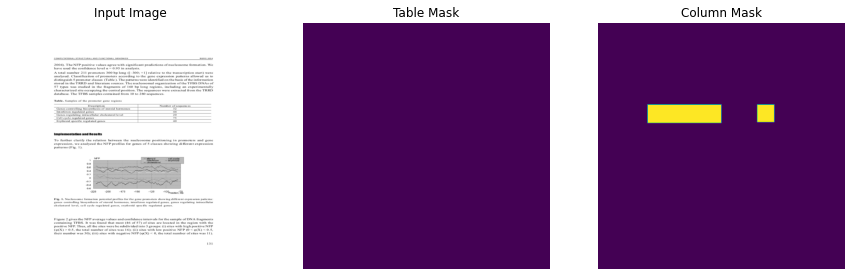

In [10]:
def display(display_list):
    plt.figure(figsize=(15, 15))
    title = ['Input Image', 'Table Mask', 'Column Mask', 'Masked image']
    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])

        image = display_list[i]

        plt.imshow(tf.keras.preprocessing.image.array_to_img(image))
        plt.axis('off')
    plt.show()



for image, mask in train.take(1):

    sample_image = image
    sample_table_mask = mask['table_mask']
    sample_col_mask = mask['col_mask']


    print(image.shape)
    print(mask['table_mask'].shape)
    print(mask['col_mask'].shape)
    display([image, mask['table_mask'], mask['col_mask']])

In [11]:
import tensorflow as tf
from tensorflow.keras.applications import VGG19
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import UpSampling2D
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K

In [12]:
"""
Table decoder
-------------
x = conv7(1x1)
x = x(upscaled) + vgg19(pool4)
x = x(upscaled) + vgg19(pool3)
x = upscaled to match input dimention (1024)


column decoder
--------------
x = conv7(1x1, relu)
x = dropout(0.8)
x = conv8(1x1)
x = upscaled() + vgg19(pool4)
x = x(upscaled) + vgg19(pool3)
x = upscaled (1024)

"""


tf.keras.backend.clear_session()


class table_mask(Layer):

    def __init__(self):
        super().__init__()
        self.conv_7 = Conv2D(kernel_size=(1,1), filters=128, kernel_regularizer=tf.keras.regularizers.l2(0.002),activation = 'relu')
        self.upsample_pool4 = UpSampling2D(size=(2, 2), interpolation='bilinear')
        self.upsample_pool3 = UpSampling2D(size=(2, 2), interpolation='bilinear')
        self.upsample_final = Conv2DTranspose(filters=2, kernel_size=3, strides=2, padding='same', activation='softmax')

    def call(self, input, pool3, pool4):
        
        x = self.conv_7(input)
        x = self.upsample_pool4(x)
        x = Concatenate()([x, pool4])
       
        x = self.upsample_pool3(x)
        x = Concatenate()([x, pool3])
        
        x = UpSampling2D((2,2))(x)
        x = UpSampling2D((2,2))(x)

        x = self.upsample_final(x)

        return x

class col_mask(Layer):
    
    def __init__(self):
        super().__init__()
        self.conv_7 = Conv2D(kernel_size=(1,1), filters=128, kernel_regularizer=tf.keras.regularizers.l2(0.004), kernel_initializer='he_normal',activation = 'relu')
        self.drop = Dropout(0.8)
        self.conv_8 = Conv2D(kernel_size=(1,1), filters=128, kernel_regularizer=tf.keras.regularizers.l2(0.004), kernel_initializer='he_normal',activation = 'relu')
        self.upsample_pool4 = UpSampling2D(size=(2, 2), interpolation='bilinear')
        self.upsample_pool3 = UpSampling2D(size=(2, 2), interpolation='bilinear')
        self.upsample_final = Conv2DTranspose(filters=2, kernel_size=3, strides=2, padding='same', activation='softmax')

    def call(self, input, pool3, pool4):
        
        x = self.conv_7(input)
        x = self.drop(x)
        x = self.conv_8(x)

        x = self.upsample_pool4(x)
        x = Concatenate()([x, pool4])
       
        x = self.upsample_pool3(x)
        x = Concatenate()([x, pool3])
        
        x = UpSampling2D((2,2))(x)
        x = UpSampling2D((2,2))(x)

        x = self.upsample_final(x)
        
        return x



input_shape = (1024, 1024, 3)
input_ = Input(shape=input_shape)

vgg19_ = VGG19(
    include_top=False,
    weights="imagenet",
    input_tensor=input_,
    input_shape=None,
    pooling=None,
    classes=1000,
    classifier_activation="softmax",
)

for layer in vgg19_.layers:
    layer.trainable = False

pool3 = vgg19_.get_layer('block3_pool').output
pool4 = vgg19_.get_layer('block4_pool').output

conv_1_1_1 = Conv2D(filters=128, kernel_size=(1, 1), activation='relu', name="block6_conv1", kernel_regularizer=tf.keras.regularizers.l2(0.004))(vgg19_.output)
conv_1_1_1_drop = Dropout(0.8)(conv_1_1_1)

conv_1_1_2 = Conv2D(filters=128, kernel_size=(1, 1), activation='relu', name="block6_conv2", kernel_regularizer=tf.keras.regularizers.l2(0.004))(conv_1_1_1_drop)
conv_1_1_2_drop = Dropout(0.8)(conv_1_1_2)

table_mask = table_mask()(conv_1_1_2_drop, pool3, pool4)
col_mask = col_mask()(conv_1_1_2_drop, pool3, pool4)

model = Model(input_, [table_mask, col_mask])

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1024, 1024,  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 1024, 1024, 6 1792        input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 1024, 1024, 6 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 512, 512, 64) 0           block1_conv2[0][0]               
______________________________________________________________________________________________

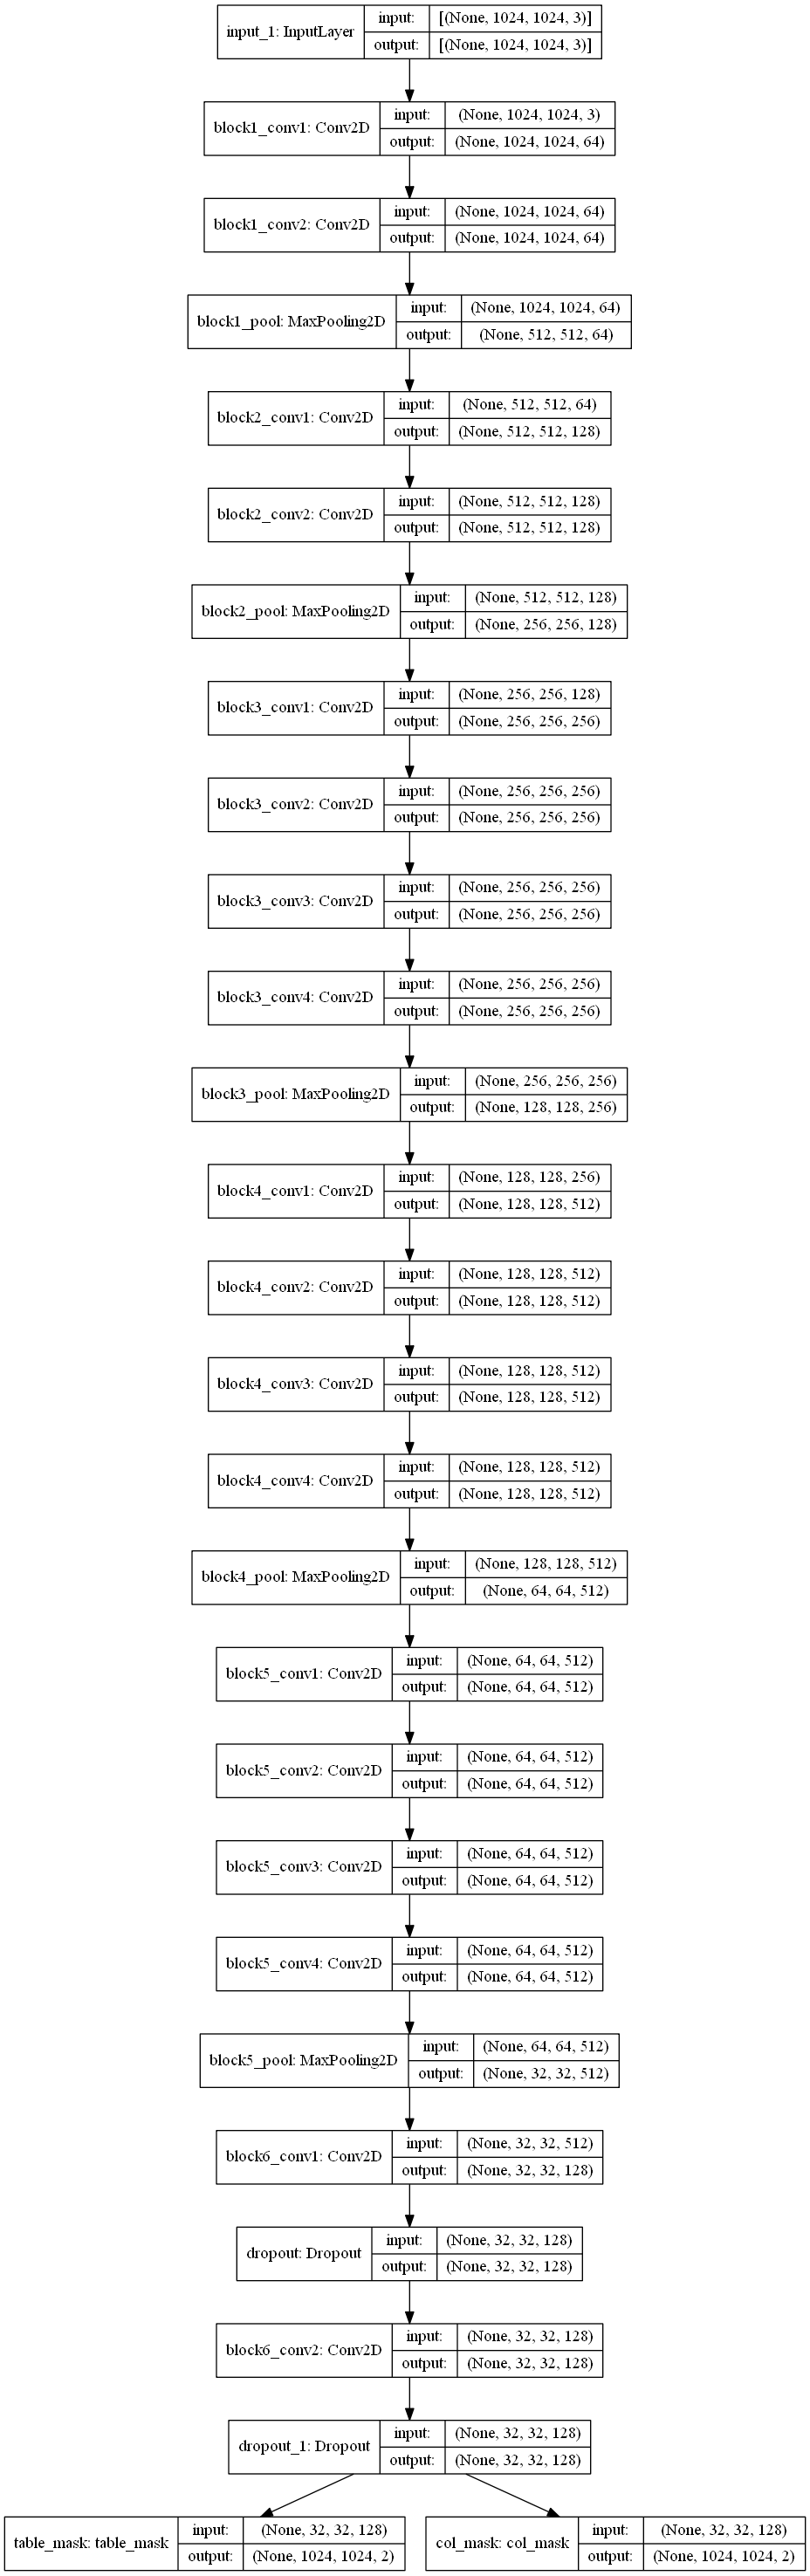

In [13]:
plot_model(model,show_shapes=True,show_layer_names=True)

In [14]:
losses = {
    "table_mask": 'sparse_categorical_crossentropy',
    "col_mask": 'sparse_categorical_crossentropy',
}

# tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)



filepath = "/content/drive/MyDrive/case study - II/tablenet/model checkpoint/table_net.h5"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath, monitor = "val_table_mask_loss", save_best_only=True, verbose = 0, mode="min")

es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=5,)


class F1_Score(tf.keras.metrics.Metric):

    def __init__(self, name='f1_score', **kwargs):
        super().__init__(name=name, **kwargs)
        self.f1 = self.add_weight(name='f1', initializer='zeros')
        self.precision_fn = tf.keras.metrics.Precision(thresholds=0.5)
        self.recall_fn = tf.keras.metrics.Recall(thresholds=0.5)

    def update_state(self, y_true, y_pred, sample_weight=None):
        p = self.precision_fn(y_true, tf.argmax(y_pred, axis=-1))
        r = self.recall_fn(y_true, tf.argmax(y_pred, axis=-1))
        # since f1 is a variable, we use assign
        self.f1.assign(2 * ((p * r) / (p + r + 1e-6)))

    def result(self):
        print("F1 Score = ",self.f1)
        return self.f1

    def reset_states(self):
        # we also need to reset the state of the precision and recall objects
        self.precision_fn.reset_states()
        self.recall_fn.reset_states()
        self.f1.assign(0)

#F1_Score(), 
metrics = [F1_Score()]
#metrics=metrics, 

global init_lr
init_lr = 0.0001

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=init_lr, epsilon=1e-8,),
              loss=losses,
              metrics=metrics, )

In [15]:
def show_predictions(dataset=None, num=1):

    if dataset:
        for image, mask in dataset.take(1):
            table_mask_pred, col_mask_pred = model.predict(image)

            table_mask_pred = tf.argmax(table_mask_pred, axis=-1)
            table_mask_pred = table_mask_pred[..., tf.newaxis][0]

            col_mask_pred = tf.argmax(col_mask_pred, axis=-1)
            col_mask_pred = col_mask_pred[..., tf.newaxis][0]

            im=tf.keras.preprocessing.image.array_to_img(image[0])
            im.save('image.png')

            im=tf.keras.preprocessing.image.array_to_img(table_mask_pred)
            im.save('table_mask_pred.png')

            im=tf.keras.preprocessing.image.array_to_img(col_mask_pred)
            im.save('col_mask_pred.png')



            img_org = Image.open('./image.png')
            table_mask = Image.open('./table_mask_pred.png')
            col_mask = Image.open('./col_mask_pred.png')


            # convert images
            img_mask = table_mask.convert('L')
            # img_mask = col_mask.convert('L')

            # grayscale
            # add alpha channel
            img_org.putalpha(img_mask)

            # save as png which keeps alpha channel
            img_org.save('output.png')


            display([image[0], table_mask_pred, col_mask_pred, img_org])

            pytesseract.pytesseract.tesseract_cmd = r'/usr/bin/tesseract'
            text = pytesseract.image_to_string(Image.open('./output.png'), lang='eng' ) # config='--psm 11'
            print(text)



class DisplayCallback(tf.keras.callbacks.Callback):

    def __init__(self):
        self.history = {'val_table_mask_loss':[]}
        self.init_lr = init_lr

    def on_epoch_end(self, epoch, logs=None):
        if epoch % 1 == 0:
            show_predictions(test_dataset, 1)
            
            
            self.history['val_table_mask_loss'].append(logs.get('val_table_mask_loss'))
            if epoch > 2:
                cur_loss = self.history['val_table_mask_loss'][epoch]
                prev_loss = self.history['val_table_mask_loss'][epoch-1]

                if cur_loss > prev_loss:
                    self.init_lr = self.init_lr * 0.93
                    K.set_value(self.model.optimizer.learning_rate, self.init_lr)

https://stackoverflow.com/questions/31653576/how-to-calculate-the-mean-iu-score-in-image-segmentation/31775111
from sklearn.metrics import confusion_matrix  
import numpy as np

def table_mask_iou(y_pred,y_true):
    # ytrue, ypred is a flatten vector
    y_pred = y_pred.flatten()
    y_true = y_true.flatten()
    y_pred = y_pred.flatten()
    y_true = y_true.flatten()
    current = confusion_matrix(y_true, y_pred, labels=[0, 1])
    # compute mean iou
    intersection = np.diag(current)
    ground_truth_set = current.sum(axis=1)
    predicted_set = current.sum(axis=0)
    union = ground_truth_set + predicted_set - intersection
    IoU = intersection / union.astype(np.float32)
    return np.mean(IoU)

EPOCHS = 50
VAL_SUBSPLITS = 30
VALIDATION_STEPS = len(X_test)//BATCH_SIZE//VAL_SUBSPLITS

history = model.fit(train_dataset,
                              epochs=EPOCHS,
                              steps_per_epoch=train_steps,
                              validation_data=test_dataset,
                              validation_steps=VALIDATION_STEPS,
                              callbacks=[model_checkpoint, es, DisplayCallback()])

In [16]:
model_path = "table_net.h5"
model.load_weights(model_path)

(1, 1024, 1024, 3)


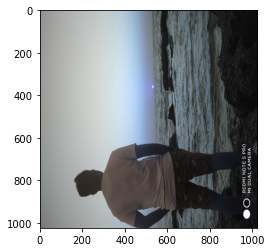

In [17]:
image = cv2.imread('d.jpg', cv2.IMREAD_UNCHANGED)
image = cv2.resize(image,(1024, 1024), cv2.INTER_NEAREST)
plt.imshow(image)
image = np.expand_dims(image, axis=0)
print(image.shape)

In [18]:
table_mask_pred, col_mask_pred = model.predict(image)

table_mask_pred = tf.argmax(table_mask_pred, axis=-1)
table_mask_pred = table_mask_pred[..., tf.newaxis][0]

col_mask_pred = tf.argmax(col_mask_pred, axis=-1)
col_mask_pred = col_mask_pred[..., tf.newaxis][0]

im=tf.keras.preprocessing.image.array_to_img(image[0])
im.save('image.png')

im=tf.keras.preprocessing.image.array_to_img(table_mask_pred)
im.save('table_mask_pred.png')

im=tf.keras.preprocessing.image.array_to_img(col_mask_pred)
im.save('col_mask_pred.png')

In [19]:
#IOU = []
#IOU_df = []
#print(np.dtype(IOU))

for image, mask in test_dataset:
    
    #print(image.shape)

    table_mask_pred, col_mask_pred = model.predict(image,batch_size = int(len(image)))

    table_mask_pred = tf.argmax(table_mask_pred, axis=-1)
    table_mask_pred = table_mask_pred[..., tf.newaxis][0]

    col_mask_pred = tf.argmax(col_mask_pred, axis=-1)
    col_mask_pred = col_mask_pred[..., tf.newaxis][0]

    table_mask_pred_flattened = tf.reshape(table_mask_pred,[-1])
    col_mask_pred_flattened = tf.reshape(col_mask_pred,[-1])
    
#     m = tf.keras.metrics.MeanIoU(num_classes=2)
#     m.update_state(table_mask_pred_flattened,col_mask_pred_flattened)
#     IOU.append(m.result().numpy())

In [20]:
#display(IOU)
#print(IOU)

IOU_df = pd.DataFrame(IOU)

print(IOU_df)

IOU_df.to_csv("IOU_latest.csv")

In [21]:
IOUdf = pd.read_csv("IOU_latest.csv")

In [22]:
print(IOUdf)

    Unnamed: 0                  Images  IOU_ratios
0            0    10.1.1.7.2164_21.bmp    0.686887
1            1   10.1.1.160.615_15.bmp    0.572552
2            2   10.1.1.193.1803_3.bmp    0.641945
3            3  10.1.1.185.1566_14.bmp    0.733550
4            4    10.1.1.13.2943_5.bmp    0.594602
..         ...                     ...         ...
94          94    10.1.1.8.2198_13.bmp    0.667552
95          95    10.1.1.160.701_6.bmp    0.684100
96          96   10.1.1.185.1552_1.bmp    0.413966
97          97   10.1.1.172.1007_3.bmp    0.563426
98          98   10.1.1.120.1527_3.bmp    0.568021

[99 rows x 3 columns]


In [25]:
IOUdf_sorted = IOUdf.sort_values(by=['IOU_ratios'])

In [26]:
print(IOUdf_sorted)

    Unnamed: 0                 Images  IOU_ratios
96          96  10.1.1.185.1552_1.bmp    0.413966
54          54  10.1.1.100.302_10.bmp    0.530280
48          48  10.1.1.190.1808_4.bmp    0.559177
44          44  10.1.1.192.1811_6.bmp    0.562024
97          97  10.1.1.172.1007_3.bmp    0.563426
..         ...                    ...         ...
43          43   10.1.1.180.557_4.bmp    0.748507
27          27  10.1.1.160.546_36.bmp    0.750432
74          74   10.1.1.40.3122_3.bmp    0.755205
60          60    10.1.1.1.2019_2.bmp    0.781485
70          70    10.1.1.1.2057_5.bmp    0.788225

[99 rows x 3 columns]


In [27]:
IOUdf_sorted.to_csv("Sorted_IOU_ratios.csv")

best = []
medium = []
worst = []

a = pd.read_csv("IOU_latest.csv", usecols=['0'])

#print(a)

for i in a.itertuples():
    print(i)
    if i=='0':
        continue
    if float(i)>=0.70:
        best.append(i)
    if float(i)>=0.58 and i<=0.65:
        medium.append(i)
    if float(i)<=0.55:
        worst.append(i)
print("**********************************************")
print("Best:",best)
print("**********************************************")
print("Medium:",medium)
print("**********************************************")
print("Worst:",worst)
print("**********************************************")

**********************************************
Best: [0.73354995, 0.7504325, 0.7273352, 0.7384416, 0.71315396, 0.7485073, 0.71735144, 0.7186574, 0.7814851, 0.7387027, 0.78822494, 0.7552048, 0.7066281, 0.7025455, 0.7294334]
**********************************************
Medium: [0.6419449, 0.594602, 0.60271955, 0.64220315, 0.62896365, 0.6481284, 0.61418533, 0.6200449, 0.63652116, 0.61110693, 0.5968022, 0.63183904, 0.6234341, 0.58831954, 0.63048756, 0.64278275, 0.6146496, 0.6349157, 0.5942844, 0.63654244, 0.59677905, 0.62716645, 0.62189436, 0.6100571, 0.6353363, 0.63046706, 0.64714867, 0.6194117, 0.62059885, 0.62035084, 0.61281496, 0.61763203, 0.6420317, 0.6460918, 0.629436, 0.6434793]
**********************************************
Worst: [0.53027964, 0.41396585]
**********************************************

(1, 1024, 1024, 3)


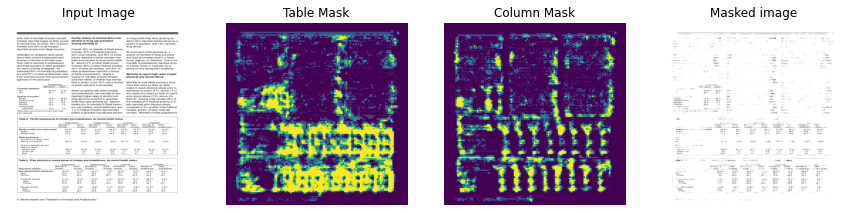

***********************************************************************************************
 

 

   

 

 

 

  

 

   

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

   

 

 

 

 

  

all Ao : aand or fe cee
ne 5 1 Boo an iy
! f
ie 4
"
ote 4 ae vere
: ion Dos uster
poutine ou : he . cr in sh
wT
med
ther .
ae = ss , rt
: 750% W es fen
1 ay also
: ree nd a
Pee tana on an o
come w rox " ri
once “a ce
peneaton a ano > ‘eiterat
soa amen em a Hi; fied ir inves
ohol rund
‘on : i
_ —— Eisien, lacnied "inmates, “amma initio,
coc ag Negi ataw bags Sts wea aoa gags
3 es bs we gens mo oaks
BS ee ee sex Ment asx
Bese ow wy ; 33
Bom an 5 2%
bie 8 a Taw : Tron” tau
ai mt Ieee weal tna, __tseataa__ neo
tena Bimer” teed ai Blnes cian E
ieee nena ana
: geo gah ongme Pgte geghe
roateaty atime! mo. 126 ag ae 0.0%
eo 28 Pt) Hy ta

***********************************************************************************************
Mean IOU =  0.53027964
******************************

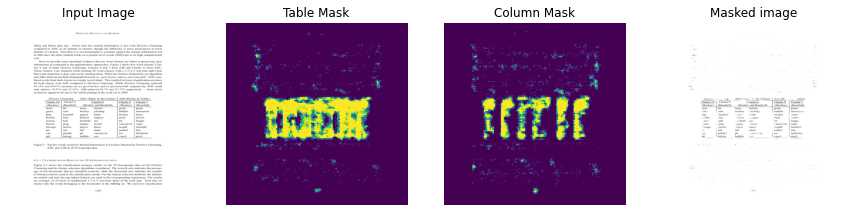

***********************************************************************************************
23 2 atl

 

 

 

 

 

  

 

 

Hivisee i tag | ADE (Bax 3: MeCallum) | Ais (Sk ashy)
Shuster 10°) "Cluster 9 ‘Chusteri> ‘Cluster 8” | Cluster 7
(ockey) | (Baseball) (Hockey and Baseball) | (Hockey) | (Baseball)
eam [hit team detroit ‘goals game
way yaseball nes bitter nockey >ases

wkey vase ayers angers puck moms
aso ball sseball nyt i league
stor: areg cague testis vancouver | roger
icage norris, yer blues negill basebaii
it ted abl shots patric hits

an pitcher pit neu wer ice ba
tht hitting: buffalo sus | coach pitch

‘ F x

 

***********************************************************************************************
Mean IOU =  0.6918371
***********************************************************************************************
(1, 1024, 1024, 3)


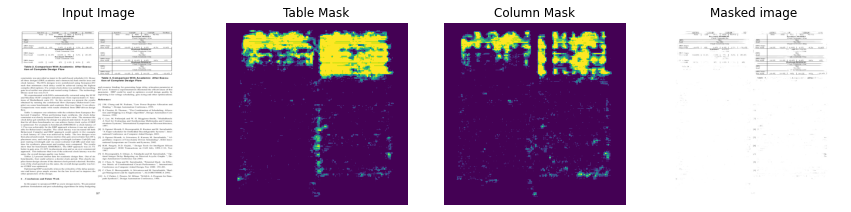

***********************************************************************************************
     

 

 

 

 

 

   

 

 

 

 

 

 

 

 

 

ena fren aa Bard ere ence =B
oe ead a ie
Star an a na
i
aac 1 perl
SET) ea ves Less oases |
“usted 3, Be. AF ane
;
ia 5
isl
rea he
ig
" iy < a

***********************************************************************************************
Mean IOU =  0.69578433
***********************************************************************************************
(1, 1024, 1024, 3)


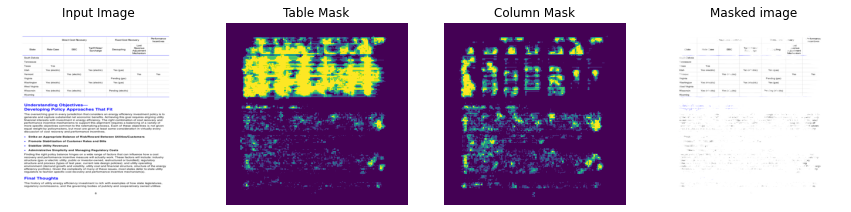

***********************************************************************************************
rect ort an enme hemes were

   

 

 

 

         

aes

= ° nue

slate Aula ase sBc Hing a. jaastement

Mectz:nism
seu Tlakota
tennessee
Fexas Yes
Utah Yes (electric) Yes (e'2tric) Yes (gas)
Yes (2 nittie} Yes Yes

virginia Pending (gas)
Washington Yes (eiatiic) ‘Yes teivetric) Yes (gas)
West Virginia
Wisconsin Yes (esti) Yes (¢stric) Per-ding (eizstde)
Wyoming _ “| _ _

wl 2

ye : —
pone a . sigs oe ee »
wiry -.

au i : ed
wor ae He cn =
win " ® '

a at '

ia #4 ye

ne ’
“pre ; :
q au Py
i 1 Me ony
4 : see 00 ing
re argu

  

***********************************************************************************************
Mean IOU =  0.5210244
***********************************************************************************************
(1, 1024, 1024, 3)


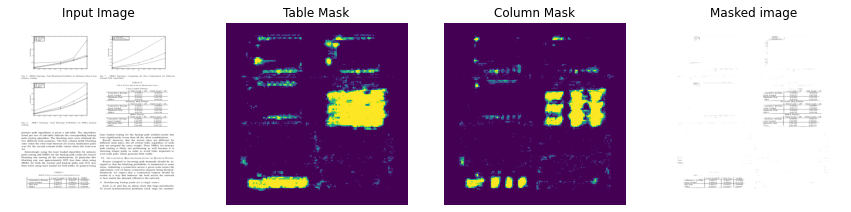

***********************************************************************************************
 

 

 

 

 

 

 

 
 

 

 

 

 

was,
Lost Loatod | tin Hp 1 eda,

wtiilanive sit ap | OGeSST | UIT | Dow T

Least Losded oos6i6 | o0s616 | 0.11728

in Hop ‘Oae527 —| 06537

NUR, 0.06527 | 0.06527 | ones”

  

1 ina Bac

fatal Lead = 44
O03

 

 

Least Loaded 0.05330
Mfininran Hop 0.03756
wes 0.01338 0.02526

 

Wiliin Hop Primary

“Total Load = ut

otal Loa = 24

 

east Loaded 0.03173 0.05035
inwitint Hop ‘Ooze 0.03 756
ages 0.01791 0.03196

MIRA Primary
‘Total Loat = 20

Toul Load = 24

 

 

 

cmalane aia C0208 TOSS
east Lowes 0.02999 o.oasa2
‘linia Hop C0526 ‘OaszTT

0.01490 0.02728

 

***********************************************************************************************
Mean IOU =  0.7175415
***********************************************************************************************
(1, 1024, 1024, 3)


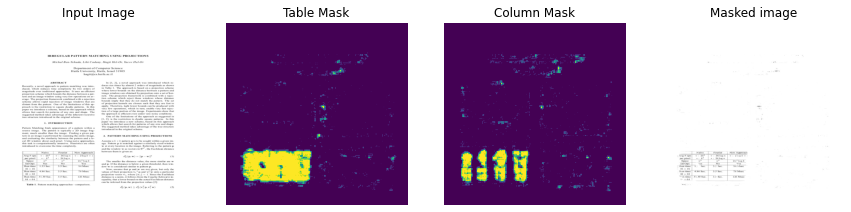

***********************************************************************************************
 

 

 

 

| Aug Fops
per pixel

 

‘Space

 

Int Ops

 

Run time
16 = 16

 

Hun time
32 = 32

 

la time
«64

 

We

 

 

 

 

 

 

9G.

 

***********************************************************************************************
Mean IOU =  0.7138675
***********************************************************************************************
(1, 1024, 1024, 3)


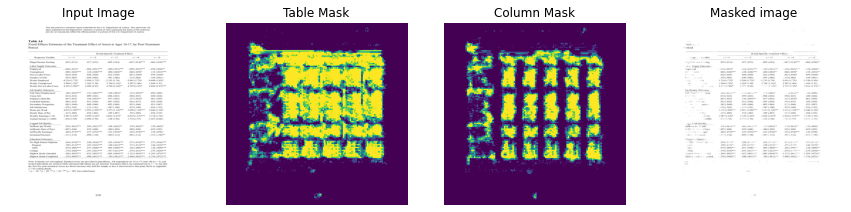

***********************************************************************************************
 

Period-Specific Treatment Effects

 

 

 

 

 

 

 

 

 

 

 

 

 

  

 

 

 

 

 

 

 

a ras2 ms t+ ras
1025 (.013)+ 017 (013) =.005 (.014) 047 (OEE) 066 (.018)*
<8 (.021)* oes (021 089 (OZT)=A" 90 L022)" 370 (.024)*~
O88 (.028)"** 128 (,028)*" 080 (.028)*! 068 (.029)* 115 (.033)*"
024 (.029) 030 (.029) 012 (.030) 061 (.030)* 079 (.034)"
838 (085) ~.030 (085) =.091 (086) =.114 (086) ~.169 (.091)>
vat 4214(1.72)" —-3.956(1.73)" —-2.193(01.74) 3.051 (1.75) 8 90,(1.85)"
2 904 (1.29)" 1.265 (1.30) 2.760.136)" 2.507 (1.40)+ 8441.51)
* $3731.90)" Z.8n7 12.03) Sez aayen 4.759 2.47)" R.E69 (2 97)"
18S CORSE EE LOn spe ime L083)" 045)" 156 (045)
914 (023) 085 (023) 206 (023) 984 (.023) 920 (024)
067 (.053) 186(.053)"* 077 (.052) 127 (.053)* 061 (.055)
983 (.036) 13 (036) 207 (036) 916 (037) 935 (.039)
982 (044) O49 (044) 002 (.044 S83 (084) 31 (.047)
876 (102) =113 (101) 47 (.100) 19 (

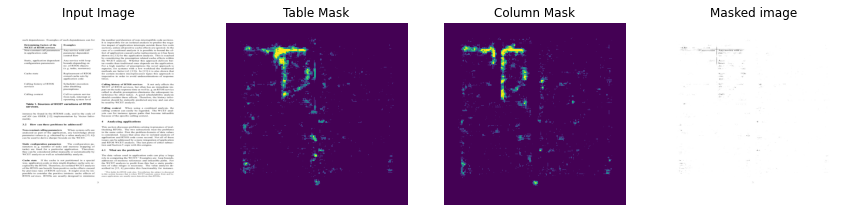

***********************************************************************************************
 

 

“eu =
TE TH palsies _| Any service wath &
rar ee

 

 

 

weet
awe
4
os
aa
an 4

***********************************************************************************************
Mean IOU =  0.6147557
***********************************************************************************************
(1, 1024, 1024, 3)


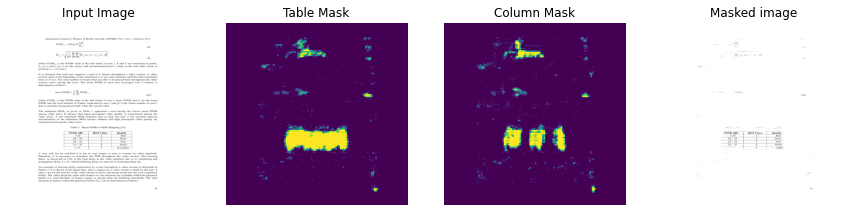

***********************************************************************************************
 

 

 

 

 

coy

 

 

 

 

 

 

 

al D s x

PSNR (dB) MOS Vaiue Quatity
<20 1 Bad
20-25 2 Poor
25— 31 3 Fair
37 a Good

as 5 7 cellent

 

 

so

***********************************************************************************************
Mean IOU =  0.71671945
***********************************************************************************************
(1, 1024, 1024, 3)


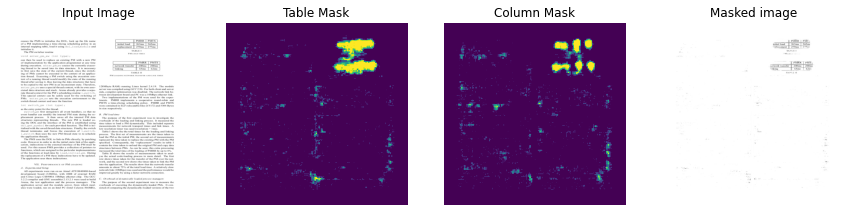

***********************************************************************************************
 

 

 

 

 

[LPMiRR | PT:
nial load [| 263ms | 265m:
Bite

fetwork

transfer

 

“aking

 

 

 

 

 

Plecement || 279ms

TABLE’
Mba

 

 

TAPLE

 

 

 

***********************************************************************************************
Mean IOU =  0.6606277
***********************************************************************************************


In [24]:
count = 0

for image, mask in test_dataset.take(10):
    
    print(image.shape)

    table_mask_pred, col_mask_pred = model.predict(image,batch_size = int(len(image)/2))

    table_mask_pred = tf.argmax(table_mask_pred, axis=-1)
    table_mask_pred = table_mask_pred[..., tf.newaxis][0]

    col_mask_pred = tf.argmax(col_mask_pred, axis=-1)
    col_mask_pred = col_mask_pred[..., tf.newaxis][0]

    im=tf.keras.preprocessing.image.array_to_img(image[0])
    im.save('image.png')

    im=tf.keras.preprocessing.image.array_to_img(table_mask_pred)
    im.save('table_mask_pred.png')

    im=tf.keras.preprocessing.image.array_to_img(col_mask_pred)
    im.save('col_mask_pred.png')



    img_org = Image.open('./image.png')
    table_mask = Image.open('./table_mask_pred.png')
    col_mask = Image.open('./col_mask_pred.png')


    # convert images
    img_mask = table_mask.convert('L')
    # img_mask = col_mask.convert('L')

    # grayscale
    # add alpha channel
    img_org.putalpha(img_mask)

    # save as png which keeps alpha channel
    img_org.save('output.png')


    display([image[0], table_mask_pred, col_mask_pred, img_org])
    
    #table_mask_iou(table_mask_pred, img_org)
    
    pytesseract.pytesseract.tesseract_cmd = r'C:/Users/sesha/AppData/Local/Programs/Tesseract-OCR/tesseract.exe'
    text = pytesseract.image_to_string(Image.open('./output.png'), lang='eng' ) # config='--psm 11'
    print("***********************************************************************************************")
    print(text)
    print("***********************************************************************************************")
    
    table_mask_pred_flattened = tf.reshape(table_mask_pred,[-1])
    col_mask_pred_flattened = tf.reshape(col_mask_pred,[-1])
    #img_org_flattened = tf.reshape(img_org,[-1])
    
    m = tf.keras.metrics.MeanIoU(num_classes=2)
    m.update_state(table_mask_pred_flattened,col_mask_pred_flattened)
    print("Mean IOU = ",m.result().numpy())
    print("***********************************************************************************************")

from prettytable import PrettyTable    
x = PrettyTable()
x.field_names = ["Image Number","MeanIOU Score"]
x.add_row(['1', '0.6466862'])
x.add_row(['2','0.625956'])
x.add_row(['3','0.7644789'])
x.add_row(['4','0.61763203'])
x.add_row(['5','0.56443346'])
x.add_row(['6','0.58016765'])
x.add_row(['7','0.7130594'])
x.add_row(['8','0.61871165'])
x.add_row(['9','0.63872015'])
x.add_row(['10','0.5968022'])
print(x)